In [86]:
import numpy as np
from statistics import median
import pandas as pd
import scipy.stats as sc
import sys
import seaborn as sns
from scipy.spatial import Delaunay
import matplotlib.pyplot as plt
from sklearn.cluster import DBSCAN
from scipy.spatial import KDTree
from matplotlib.gridspec import GridSpec


# Set seed for reproducibility
np.random.seed(12)
print(sys.executable)

/Users/isabellegarnreiter/opt/anaconda3/envs/vesicleSTORM/bin/python


In [15]:
import numpy as np
from scipy.spatial import Delaunay
import matplotlib.pyplot as plt
from sklearn.cluster import DBSCAN

# Set seed for reproducibility
np.random.seed(12)

def get_triangle_areas(triangulation, points):
    triangle_areas = []
    for simplex in triangulation.simplices:
        triangle = points[simplex]
        triangle_area = 0.5 * np.abs(np.cross(triangle[1] - triangle[0], triangle[2] - triangle[0]))
        triangle_areas.append(triangle_area)
    return triangle_areas


def edge_length(vertex1, vertex2):
    return np.linalg.norm(vertex2 - vertex1)

def get_edge_length(triangulation, points):
# Calculate edge lengths for each simplex
    edge_lengths = []
    for simplex in triangulation.simplices:
        for i in range(3):
            edge_lengths.append(edge_length(points[simplex[i]], points[simplex[(i + 1) % 3]]))
    return(edge_lengths)

In [17]:
#upload csv file
data_file = '/Volumes/Seagate/Elisa_STORM/HRP/Good/storm_data.pkl'
storm_data = pd.read_pickle(data_file)

#data filtering 
storm_data['markertype and DIV'] = storm_data['647nm'] + storm_data['DIV']

#remove data in which the mean nearest neighbour distance from 1 channel to another is above a certain threshold. this value might differe depending on the targeted markers.
storm_data = storm_data[storm_data['mean_coloc_680'] <=1000]

#filter out clusters which are too small. Including these tiny clusters might create problems in the analysis. 
storm_data = storm_data[storm_data['volume'] >= 0.0266]
storm_data = storm_data[storm_data['volume'] <= 2]

#remove clusters which contain too many or too few points
storm_data = storm_data[storm_data['point count'] >=50]
stormstorm_data = storm_data[storm_data['point count'] <=10000]

In [18]:
storm_data = storm_data[storm_data['647nm'] =='spon647']

points_spon = list(storm_data['points_647'])
print('nb of spon points', len(points_spon))
points_dep = list(storm_data['points_680'])
print('nb of dep points', len(points_dep))

points_spon_filtered = []
points_dep_filtered = []
for i in range(0, len(points_spon)):
    nb_spon = len(points_spon[i])
    nb_dep = len(points_dep[i])

    if abs(nb_spon-nb_dep) > nb_dep or abs(nb_spon-nb_dep) > nb_spon:
        pass
    else:
        points_spon_filtered.append(points_spon[i])
        points_dep_filtered.append(points_dep[i])




nb of spon points 53
nb of dep points 53


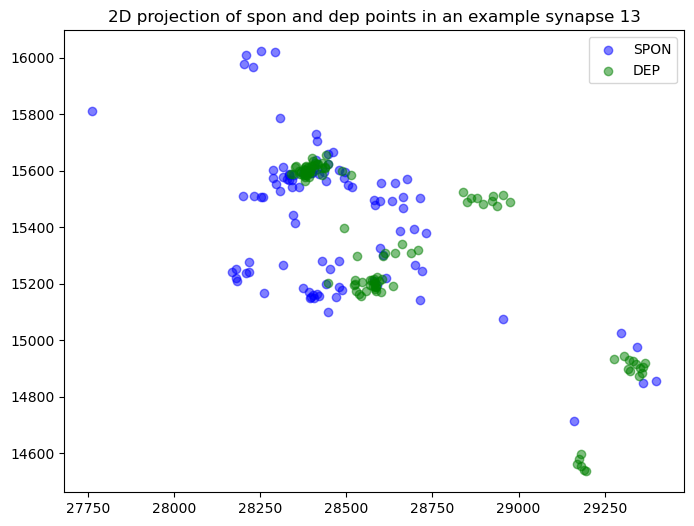

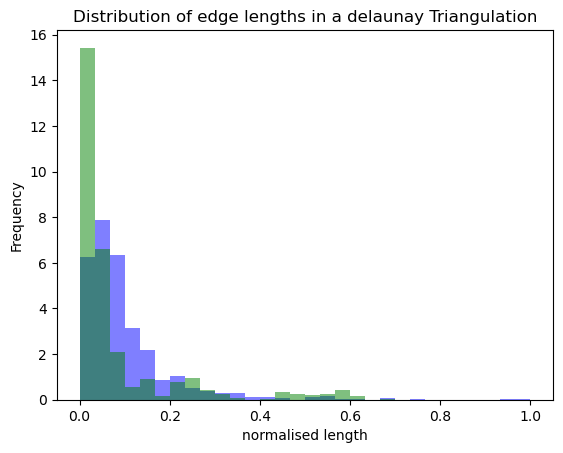

202
(3, 202)


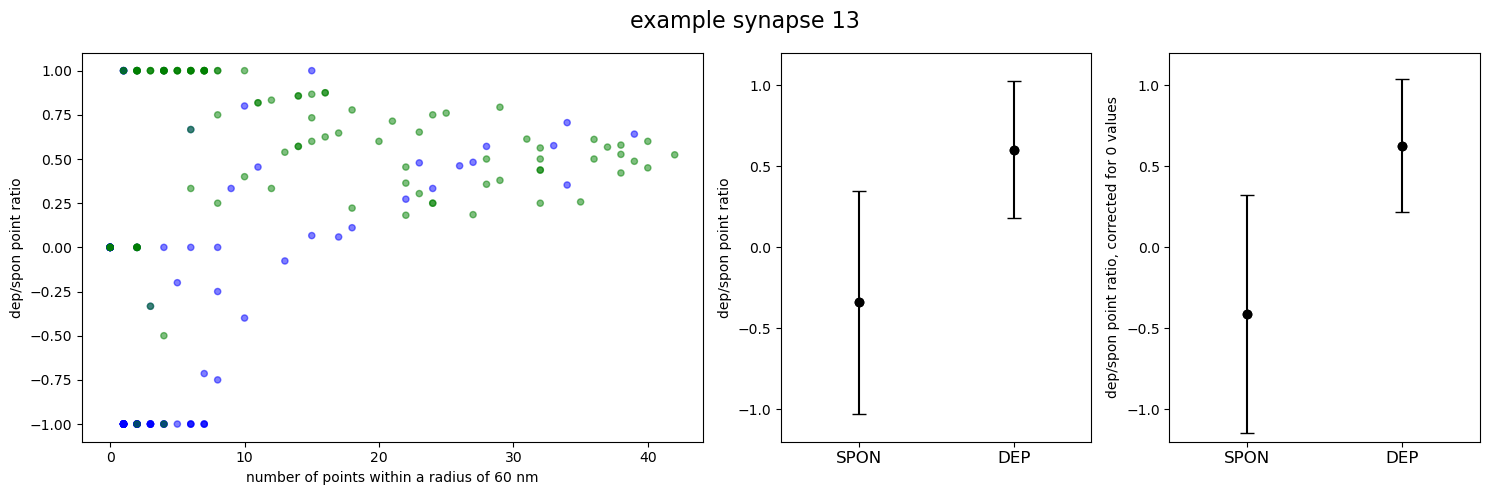

In [179]:

# Set seed for reproducibility
np.random.seed(12)

# Function to generate points with clusters and noise
def generate_clustered_points(num_points_per_cluster, num_clusters, noise_std, noisy_points):
    points = []

    for cluster in range(num_clusters):
        # Generate cluster center
        center = np.random.rand(2) * 10  # Adjust the scale as needed

        # Generate points around the cluster center with noise
        cluster_points = center + np.random.normal(scale=noise_std, size=(num_points_per_cluster, 2))
        noise = np.random.rand(noisy_points, 2) * 10
        points.extend(cluster_points)
    points.extend(noise)

    return np.array(points)

def get_triangle_areas(triangulation, points):
    triangle_areas = []
    for simplex in triangulation.simplices:
        triangle = points[simplex]
        triangle_area = 0.5 * np.abs(np.cross(triangle[1] - triangle[0], triangle[2] - triangle[0]))
        triangle_areas.append(triangle_area)
    return triangle_areas

def get_tetrahedron_volumes(triangulation, points):
    tetrahedron_volumes = []
    for simplex in triangulation.simplices:
        tetrahedron = points[simplex]
        tetrahedron_volume = np.abs(np.dot(tetrahedron[0] - tetrahedron[3], np.cross(tetrahedron[1] - tetrahedron[3], tetrahedron[2] - tetrahedron[3]))) / 6.0
        tetrahedron_volumes.append(tetrahedron_volume)
    return tetrahedron_volumes


def edge_length(vertex1, vertex2):
    return np.linalg.norm(vertex2 - vertex1)

def get_edge_length(triangulation, points):
# Calculate edge lengths for each simplex
    edge_lengths = []
    for simplex in triangulation.simplices:
        for i in range(3):
            edge_lengths.append(edge_length(points[simplex[i]], points[simplex[(i + 1) % 3]]))
    return(edge_lengths)

def get_ratio(points1, points2):
    ratio = []
    for point1, point2 in zip(points1, points2):
        if point1+point2!=0:
            r = (point1-point2)/(point1+point2)
            ratio.append(r)
        else:
            ratio.append(0)
    return ratio


syn_nb = 13
# Generate random points
random_points = points_spon_filtered[syn_nb]
# Generate clustered points with noise
clustered_points = points_dep_filtered[syn_nb]

# Concatenate random and clustered points
all_points = np.concatenate((random_points, clustered_points), axis=0)
source_indicator = np.concatenate((np.zeros(len(random_points)), np.ones(len(clustered_points))))

# Perform Delaunay triangulation
triangulation_cluster = Delaunay(clustered_points)
triangulation_rand = Delaunay(random_points)


#get the distance of the vertices and normalise
tr_dist_cluster = get_edge_length(triangulation_cluster, clustered_points)
tr_dist_rand = get_edge_length(triangulation_rand, random_points)
max_tr_dist = max(*tr_dist_rand, *tr_dist_cluster)
tr_dist_rand_norm = [x/max_tr_dist for x in tr_dist_rand]
tr_dist_cluster_norm = [x/max_tr_dist for x in tr_dist_cluster]

#get the area of the vertices and normalise
trarea_rand = get_tetrahedron_volumes(triangulation_rand, random_points)
trarea_clustered = get_tetrahedron_volumes(triangulation_cluster, clustered_points)
max_tr_area = max(*trarea_rand, *trarea_clustered)
trarea_rand_norm = [x/max_tr_area for x in trarea_rand]
trarea_clustered_norm = [x/max_tr_area for x in trarea_clustered]


colors = ['blue', 'green']

# Plotting
plt.figure(figsize=(8, 6))
# Plot random points in blue
plt.scatter(random_points[:, 0], random_points[:, 1], c=colors[0], label='SPON', alpha=0.5)
# Plot clustered points in orange
plt.scatter(clustered_points[:, 0], clustered_points[:, 1], c=colors[1], label='DEP', alpha=0.5)
# Plot Delaunay triangulation
#plt.triplot(clustered_points[:, 0], clustered_points[:, 1], triangulation_cluster.simplices, color='orange')
#plt.triplot(random_points[:, 0], random_points[:, 1], triangulation_rand.simplices, color='blue')

plt.title(f'2D projection of spon and dep points in an example synapse {syn_nb}')
plt.legend()
plt.show()

bins = np.linspace(0, 1, 31) 
plt.hist(tr_dist_rand_norm, bins=bins, color=colors[0], alpha=0.5, density=True)
plt.hist(tr_dist_cluster_norm, bins=bins, color=colors[1], alpha=0.5, density=True)
plt.xlabel('normalised length')
plt.ylabel('Frequency')
plt.title('Distribution of edge lengths in a delaunay Triangulation')
plt.show()


# Build KD-tree
kdtree_spon = KDTree(random_points)
kdtree_dep = KDTree(clustered_points)

# Radius for neighbors
radius = 60

# Count neighbors for each point
nn_spon = [len(kdtree_spon.query_ball_point(point, radius)) - 1 for point in random_points] + [len(kdtree_spon.query_ball_point(point, radius)) for point in clustered_points]
nn_dep = [len(kdtree_dep.query_ball_point(point, radius)) for point in random_points]+[len(kdtree_dep.query_ball_point(point, radius))-1 for point in clustered_points]

nn_tot = [element1 + element2 for element1, element2 in zip(nn_spon, nn_dep)]
print(len(nn_tot))
ratio = get_ratio(nn_dep, nn_spon)

means_spon = np.mean([ratio[i] for i in range(len(ratio)) if source_indicator[i]==0])
means_dep = np.mean([ratio[i] for i in range(len(ratio)) if source_indicator[i]==1])
stdev_spon = np.std([ratio[i] for i in range(len(ratio)) if source_indicator[i]==0])
stdev_dep = np.std([ratio[i] for i in range(len(ratio)) if source_indicator[i]==1])

#correct for when there are no points.
ensemble = np.array([ratio, nn_tot, source_indicator])
corr = []
print(ensemble.shape)
for i in range(ensemble.shape[1]):
    if ensemble[1,i] != 0:
        corr.append(ensemble[:,i])

corr=np.array(corr)

fig = plt.figure(figsize=(15, 5))
plt.suptitle(f'example synapse {syn_nb}', fontsize=16)
spec = GridSpec(1, 3, width_ratios=[2, 1, 1])

axes0 = fig.add_subplot(spec[0, 0])
axes0.scatter(nn_tot, ratio, c=np.array(colors)[source_indicator.astype(int)], s=20, alpha=0.5)
axes0.set_xlabel(f'number of points within a radius of {radius} nm')
axes0.set_ylabel('dep/spon point ratio')

axes1 = fig.add_subplot(spec[0, 1])
#axes1.scatter(source_indicator, ratio, c=np.array(colors)[source_indicator.astype(int)], alpha=0.5)
axes1.scatter([0,1], [means_spon, means_dep], c='black')
axes1.errorbar([0, 1], [means_spon, means_dep], yerr=[stdev_spon, stdev_dep], fmt='o', color='black', capsize=5)
axes1.set_xlim(-0.5, 1.5)
axes1.set_xticks([0, 1])
axes1.set_ylim(-1.2, 1.2)
axes1.set_xticklabels(['SPON', 'DEP'], fontsize=12)
axes1.set_ylabel('dep/spon point ratio')

axes2 = fig.add_subplot(spec[0, 2])
#axes2.scatter(corr[:,2], corr[:,0], c=np.array(colors)[corr[:,2].astype(int)], alpha=0.5)
axes2.scatter([0,1], [np.mean(corr[corr[:,2]==0,0]), np.mean(corr[corr[:,2]==1,0])], c='black')
axes2.errorbar([0, 1], [np.mean(corr[corr[:,2]==0,0]), np.mean(corr[corr[:,2]==1,0])], yerr=[np.std(corr[corr[:,2]==0,0]), np.std(corr[corr[:,2]==1,0])], fmt='o', color='black', capsize=5)
axes2.set_xticks([0, 1])
axes2.set_xlim(-0.5, 1.5)
axes2.set_ylim(-1.2, 1.2)
axes2.set_xticklabels(['SPON', 'DEP'], fontsize=12)
axes2.set_ylabel('dep/spon point ratio, corrected for 0 values')

plt.tight_layout()


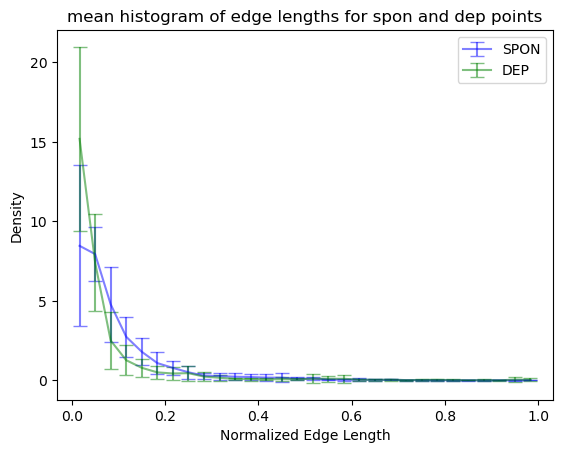

[-0.5590133824830218, 0.7043485930343035]
[-0.6745001013283681, 0.7616376579724605]


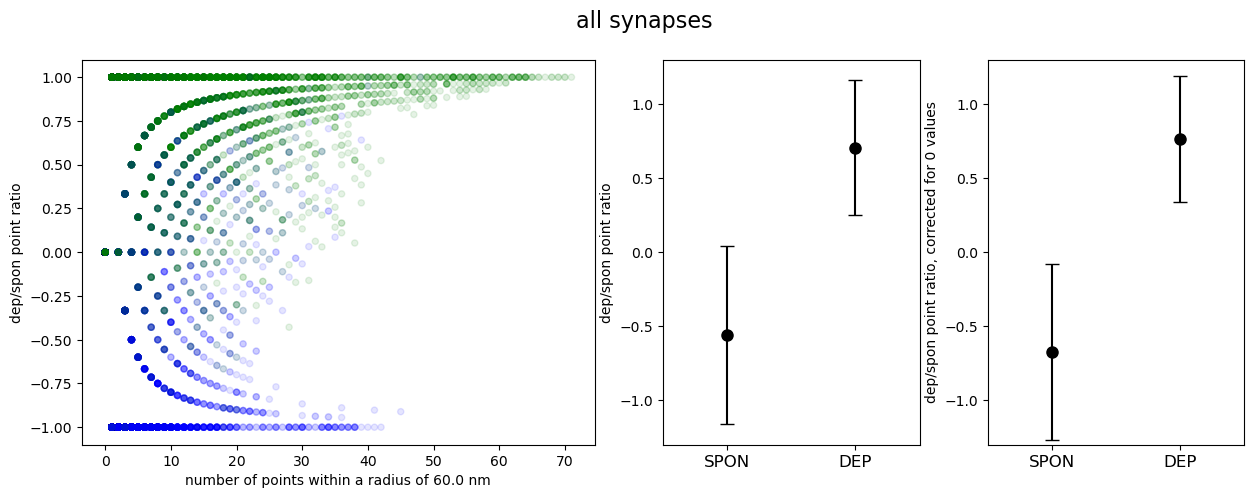

In [181]:
hist_cluster_all = []
hist_rand_all = []
ensemble_all = []
corr_all = []

for i in range(len(points_spon_filtered)):
    # Generate random points
    random_points = points_spon_filtered[i]

    # Generate clustered points with noise
    clustered_points = points_dep_filtered[i]

    # Concatenate random and clustered points
    all_points = np.concatenate((random_points, clustered_points), axis=0)
    source_indicator = np.concatenate((np.zeros(len(random_points)), np.ones(len(clustered_points))))

    # Perform Delaunay triangulation
    triangulation_cluster = Delaunay(clustered_points)
    triangulation_rand = Delaunay(random_points)

    #get the distance of the vertices and normalise
    tr_dist_cluster = get_edge_length(triangulation_cluster, clustered_points)
    tr_dist_rand = get_edge_length(triangulation_rand, random_points)
    max_tr_dist = max(*tr_dist_rand, *tr_dist_cluster)
    tr_dist_rand_norm = tr_dist_rand/max_tr_dist
    tr_dist_cluster_norm = tr_dist_cluster/max_tr_dist
    
    hist_rand = np.histogram(tr_dist_rand_norm, bins = np.linspace(0,1,31),density=True)
    hist_cluster = np.histogram(tr_dist_cluster_norm, bins = np.linspace(0,1,31),density=True)
    hist_rand_all.append(hist_rand)
    hist_cluster_all.append(hist_cluster)

    # Build KD-tree
    kdtree_spon = KDTree(random_points)
    kdtree_dep = KDTree(clustered_points)

    # Radius for neighbors
    radius = 60.0

    # Count neighbors for each point
    nn_spon = [len(kdtree_spon.query_ball_point(point, radius)) - 1 for point in random_points] + [len(kdtree_spon.query_ball_point(point, radius)) for point in clustered_points]
    nn_dep = [len(kdtree_dep.query_ball_point(point, radius)) for point in random_points]+[len(kdtree_dep.query_ball_point(point, radius))-1 for point in clustered_points]

    nn_tot = [element1 + element2 for element1, element2 in zip(nn_spon, nn_dep)]
    ratio = get_ratio(nn_dep, nn_spon)

    #correct for when there are no points.
    ensemble = np.array([ratio, nn_tot, source_indicator]).T
    corr = []
    for i in range(ensemble.shape[0]):
        if ensemble[i,0] != 0:
            corr.append(ensemble[i,:])

    corr=np.array(corr)
    ensemble_all.append(ensemble)
    corr_all.append(corr)

ensemble_all = np.concatenate(ensemble_all, axis=0)
corr_all = np.concatenate(corr_all, axis=0)

# Calculate the mean histogram for the cluster condition
mean_hist_cluster = np.mean(np.array([hist[0] for hist in hist_cluster_all]), axis=0)
std_hist_cluster = np.std(np.array([hist[0] for hist in hist_cluster_all]), axis=0)

# Calculate the mean histogram for the random condition
mean_hist_rand = np.mean(np.array([hist[0] for hist in hist_rand_all]), axis=0)
std_hist_rand = np.std(np.array([hist[0] for hist in hist_rand_all]), axis=0)

# Plot the mean histograms with error bars
bin_edges = hist_rand_all[0][1]  # Assuming all histograms have the same bin edges
bin_centers = (bin_edges[:-1] + bin_edges[1:]) / 2


colors = ['blue', 'green']
plt.errorbar(bin_centers, mean_hist_rand, yerr=std_hist_rand, label='SPON', c=colors[0], capsize=5, alpha=0.5)
plt.errorbar(bin_centers, mean_hist_cluster, yerr=std_hist_cluster, label='DEP', c=colors[1], capsize=5, alpha=0.5)
plt.xlabel('Normalized Edge Length')
plt.ylabel('Density')
plt.title('mean histogram of edge lengths for spon and dep points')
plt.legend()
plt.show()



fig = plt.figure(figsize=(15, 5))
spec = GridSpec(1, 3, width_ratios=[2, 1, 1])
plt.suptitle(f'all synapses', fontsize=16)


axes0 = fig.add_subplot(spec[0, 0])
axes0.scatter(ensemble_all[:,1], ensemble_all[:,0], c=np.array(colors)[ensemble_all[:,2].astype(int)], s=20, alpha=0.1)
axes0.set_xlabel(f'number of points within a radius of {radius} nm')
axes0.set_ylabel('dep/spon point ratio')


axes1 = fig.add_subplot(spec[0, 1])
#axes1.scatter(ensemble_all[:,2], ensemble_all[:,0], c=np.array(colors)[ensemble_all[:,2].astype(int)], alpha=0.5)
axes1.errorbar([0, 1], [np.mean(ensemble_all[ensemble_all[:,2]==0,0]), np.mean(ensemble_all[ensemble_all[:,2]==1,0])], yerr=[np.std(ensemble_all[ensemble_all[:,2]==0,0]), np.std(ensemble_all[ensemble_all[:,2]==1,0])], fmt='o', c='black', markersize = 8, capsize=5)
axes1.scatter([0,1], [np.mean(ensemble_all[ensemble_all[:,2]==0,0]), np.mean(ensemble_all[ensemble_all[:,2]==1,0])], c=colors)
axes1.set_xlim(-0.5, 1.5)
axes1.set_xticks([0, 1])
axes1.set_ylim(-1.3, 1.3)
axes1.set_xticklabels(['SPON', 'DEP'], fontsize=12)
axes1.set_ylabel('dep/spon point ratio')



axes2 = fig.add_subplot(spec[0, 2])
#axes2.scatter(corr_all[:,2], corr_all[:,0], c=np.array(colors)[corr_all[:,2].astype(int)], alpha=0.5)
axes2.errorbar([0, 1], [np.mean(corr_all[corr_all[:,2]==0,0]), np.mean(corr_all[corr_all[:,2]==1,0])], yerr=[np.std(corr_all[corr_all[:,2]==0,0]), np.std(corr_all[corr_all[:,2]==1,0])], fmt='o', c='black', markersize=8, capsize=5)
axes2.scatter([0,1], [np.mean(corr_all[corr_all[:,2]==0,0]), np.mean(corr_all[corr_all[:,2]==1,0])], c=colors)
axes2.set_xticks([0, 1])
axes2.set_xlim(-0.5, 1.5)
axes2.set_ylim(-1.3, 1.3)
axes2.set_xticklabels(['SPON', 'DEP'], fontsize=12)
axes2.set_ylabel('dep/spon point ratio, corrected for 0 values')

print([np.mean(ensemble_all[ensemble_all[:,2]==0,0]), np.mean(ensemble_all[ensemble_all[:,2]==1,0])])
print([np.mean(corr_all[corr_all[:,2]==0,0]), np.mean(corr_all[corr_all[:,2]==1,0])])

In [12]:

# # Apply DBSCAN to the normalized data
# dbscan = DBSCAN(eps=2, min_samples=20)
# labels_clustered = dbscan.fit_predict(clustered_points)
# labels_rand = dbscan.fit_predict(random_points)

# plt.scatter(random_points[:, 0], random_points[:, 1], alpha=1)
# for label in unique_labels_rand:
#     mask = labels_rand == label
#     if np.any(mask):
#         print(mask)
#         plt.scatter(random_points[mask, 0], random_points[mask, 1])

# plt.title("DBSCAN Clusters in the random data")
# plt.legend()
# plt.show()

# plt.scatter(clustered_points[:, 0], clustered_points[:, 1], alpha=1)
# for label in unique_labels_clustered:
#     mask = labels_clustered == label
#     if np.any(mask):
#         plt.scatter(clustered_points[mask, 0], clustered_points[mask, 1])

# plt.title("DBSCAN Clusters in the clustered data")
# plt.legend()
# plt.show

-1.0